In [87]:
import csv
import json
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
import numpy
import random
import gzip
import math
import sklearn
import statistics
import pandas as pd
import string
import seaborn as sns


In [1]:
def parseDataFromFile(fname):
  for l in open(fname):
    yield eval(l)

In [156]:
d = list(parseDataFromFile("ratebeer.json"))

In [159]:
#get the first 200000 reviews to work with 
dataset = d[:200000]
len(dataset)

200000

In [160]:
#get rid of '/20' for the reviews so they can be manipulated as int
for d in dataset:
    d['review/overall'] = int(d['review/overall'][:-3])

In [257]:
dataTrain = dataset[:160000]
dataTest = dataset[-40000:]

In [21]:
#Get items per user, users per beer, ratingDict, user/item averages 

usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair
for d in dataset:
    user,item = d['review/profileName'], d['beer/beerId']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingDict[(user,item)] = d['review/overall']
    itemNames[item] = d['beer/name']

In [39]:
#get user averages, item averages
userAverages = {}
itemAverages = {}
for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs) 
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

#global average (trivial predictor)
ratingMean = sum([d['review/overall'] for d in dataset]) / len(dataset)    

#get reviews per user, reviews per item
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
for d in dataset:
    user,item = d['review/profileName'], d['beer/beerId']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    

In [271]:
#similarity function
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

#returns most similar N items to item i 
def mostSimilarFast(i, N):
    similarities = []
    users = usersPerItem[i]
    candidateItems = set()
    for u in users:
        candidateItems = candidateItems.union(itemsPerUser[u])
    for i2 in candidateItems:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

#similarity based rating predictor
def predictRatingSimilar(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['beer/beerId']
        if i2 == item: continue
        ratings.append(d['review/overall'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

def predictRatingAverage(user,item):
    return (userAverages[user] + itemAverages[item])/2
    
#mean squared error function
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [266]:
#trivial predictor
alwaysPredictMean = [ratingMean for d in dataTrain]

#average based predictor 
avgPredictions = [predictRatingAverage(d['review/profileName'], d['beer/beerId']) for d in dataTrain]

#similarity based predictor
#simPredictions = [predictRatingSimilar(d['review/profileName'], d['beer/beerId']) for d in dataTrain]
#correct ratings
labels = [d['review/overall'] for d in dataTrain]

In [267]:
trivialSolutionError = MSE(alwaysPredictMean, labels)
AverageBasedSolutionError = MSE(avgPredictions,labels)
#SimilarityBasedSolutionError = MSE(simPredictions, labels)

print('trivialSolution MSE: ' + str(trivialSolutionError) + '\n' +
      'AverageBasedSolution MSE: ' + str(AverageBasedSolutionError) + '\n' + 
      'SimilarityBasedSolution MSE: ' + str(SimilarityBasedSolutionError) )

trivialSolution MSE: 8.902283718749056
AverageBasedSolution MSE: 4.6514150448553195
SimilarityBasedSolution MSE: 4.138836662643502


Most popular words

In [63]:
syncategorematic = ['a' , 'and', 'the', 'with', 'of', 'is', 'to', 'in', 'this', 'i', 'it',
                    'that', 'of', 'can', 'get', 'me']
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain: # Strictly, should just use the *training* data to extract word counts
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w not in syncategorematic:
            wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

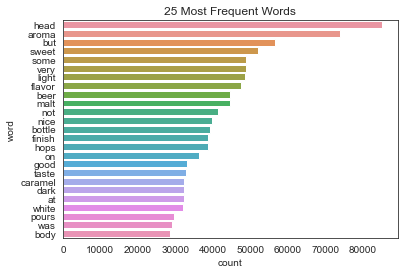

In [86]:
#plotting 25 most frequent words
mostFrequent = counts[:25]
mf = pd.DataFrame(mostFrequent)
mf = mf.rename(columns = {0:'count', 1:'word'})
sns.set_style("white")
sns.color_palette("viridis")
g3 = sns.barplot(x=mf['count'], y=mf['word'], data = mf)
g3.set_title('25 Most Frequent Words')
fig = g3.figure
fig.savefig('mostfreq.png')

In [246]:
#extrating words that are highly influential on the rating`
words = [x[1] for x in counts[:2000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [95]:
#bag of words feature
def bowFeature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in wordSet and w not in syncategorematic:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [97]:
X = [bowFeature(d) for d in dataTrain]
y = [d['review/overall'] for d in dataTrain]
theta,residuals,rank,s = numpy.linalg.lstsq(X, y)

/var/folders/30/f8mvs3gj01q3w9720r4w3_2h0000gn/T/ipykernel_99464/753861316.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta,residuals,rank,s = numpy.linalg.lstsq(X, y)


In [110]:
wordWeights = list(zip(theta, words + ['offset']))
wordWeights.sort()
positiveWords = wordWeights[-11:]
positiveWords = positiveWords[:10]
negativeWords = wordWeights[:10]

In [113]:
influential = positiveWords + negativeWords
influential

[(0.8683677415095801, 'wonderful'),
 (0.8720207696200999, 'awesome'),
 (0.8956612296648663, '750'),
 (0.9009876444178266, 'outstanding'),
 (0.9284918081442406, 'incredible'),
 (0.9771256906856268, 'excellent'),
 (1.0255599923233547, 'delicious'),
 (1.0517116954432582, 'loved'),
 (1.15194215586296, 'favorites'),
 (1.564605389452252, 'arme'),
 (-2.7890748084321575, 'nasty'),
 (-2.686402701672263, 'worst'),
 (-2.554027431925854, 'awful'),
 (-2.188352059936839, 'skunky'),
 (-2.1068494162764226, 'horrible'),
 (-2.0918410774696365, 'antrunk'),
 (-1.927951665356829, 'chemical'),
 (-1.903882995493414, 'terrible'),
 (-1.8114400238510435, 'infected'),
 (-1.75237770504889, 'corny')]

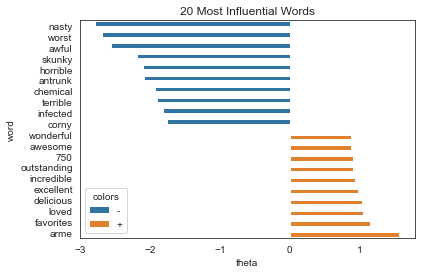

In [120]:
#plotting 25 most frequent words

infl = pd.DataFrame(influential).sort_values(0)
infl = infl.rename(columns = {0:'theta', 1:'word'})
infl['colors'] = ['+' if c >= 0 else '-' for c in infl['theta']]
sns.set_style("white")
sns.color_palette("viridis")
g3 = sns.barplot(x='theta', y='word', data = infl, hue = 'colors')
g3.set_title('20 Most Influential Words')
fig = g3.figure
fig.savefig('mostfreq.png')

In [177]:
positive50Words = wordWeights[-501:]
positive50Words = positiveWords[:500]
negative50Words = wordWeights[:500]
top100Words = positive50Words + negative50Words

top100wordId = dict(zip(top100Words, range(len(top100Words))))
top100wordSet = set(top100Words)

In [128]:
beers = pd.DataFrame(dataset)

In [162]:
#preprocessing ABV and ratings
beers.loc[beers["beer/ABV"] == '-', 'beer/ABV'] = 0
beers['beer/ABV'] = beers['beer/ABV'].astype(float)
abvs_float = beers['beer/ABV'].to_list()
for i in range(len(dataset)):
    dataset[i]['beer/ABV'] = abvs_float[i]
    dataset[i]['review/appearance'] =  float(dataset[i]['review/appearance'][:-2])
    dataset[i]['review/aroma'] =  float(dataset[i]['review/aroma'][:-3])
    dataset[i]['review/palate'] =  float(dataset[i]['review/palate'][:-2])
    dataset[i]['review/taste'] =  float(dataset[i]['review/taste'][:-3])




In [295]:
#feature vector to include bow, ABV, user avg, beer avg, beer qualities 
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    beer = datum['beer/beerId']
    user = datum['review/profileName']
    feat.append(userAverages[user])
    feat.append(itemAverages[beer])
    feat.append(datum['beer/ABV'])
    feat.append(datum['review/appearance'])
    feat.append(datum['review/aroma'])
    feat.append(datum['review/palate'])
    feat.append(datum['review/taste'])
    #ms = mostSimilarFast(beer,3)
    #considering most 10 similar beers avg 
    #for i in ms:
    #    if i[0] > 0.3:
    #        feat.append(itemAverages[i[1]])
    
    return feat

In [296]:
Xtrain = [feature(d) for d in dataTrain]
ytrain = [d['review/overall'] for d in dataTrain]
Xtest = [feature(d) for d in dataTest]
ytest = [d['review/overall'] for d in dataTest]

In [297]:
model = sklearn.linear_model.LogisticRegression()
model.fit(Xtrain,ytrain)

/Users/tylerhouchin/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [298]:
pred = model.predict(Xtest)

In [299]:
print(MSE(pred,ytest))

3.321925
